In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import random, uniform
import math

In [7]:
class GenerateData:
    @staticmethod
    def generate_linear(n=100):
        pts = np.random.uniform(0, 1, (n, 2))
        inputs = []
        labels = []
        for pt in pts:
            inputs.append([pt[0], pt[1]])
            distance = (pt[0] - pt[1]) / 1.414
            if pt[0] > pt[1]:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(inputs), np.array(labels).reshape(n, 1)
    
    @staticmethod
    def generate_XOR_easy():
        inputs = []
        labels = []

        for i in range(11):
            inputs.append([0.1*i, 0.1*i])
            labels.append(0)

            if 0.1*i == 0.5:
                continue

            inputs.append([0.1*i, 1-0.1*i])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape(21, 1)

In [3]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth", fontsize = 18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize = 18)
    for i in range(x.shape[0]):
        if abs(pred_y[i]) >=0.9:
            plt.plot(x[i][0], x[i][1], 'bo')
            print("print Blue", pred_y[i])
        else:
            plt.plot(x[i][0], x[i][1], 'ro')
            print("print Red", pred_y[i])
            
    plt.show()

In [ ]:
# def learningCurve(n_epoch, loss):
#     plt.title("Learning Curve", fontsize = 18)
#     plt.plot([x for x in range(1,n_epoch+1)], loss,color='blue', label="learning curve")
#     plt.legend(loc = 'upper right')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.show()

In [43]:
class SimpleNN:
    def __init__(self):
        self.network = list()
        self.neuronNum = list()
        self.l_rate = 0.01
        self.n_epoch = 1000
        self.haveLearningCurve = True
        seed(1)
    def addLayer(self, n_neuron, **karg):
        if "n_inputs" in karg.keys():
            #This is input layer
            n_inputs = karg['n_inputs']
            inputLayer = [{"weight":[uniform(-1,1)  for __ in range(n_inputs+1)]}for _ in range(n_neuron)] #weight[-1] is for Bias
            self.network.append(inputLayer)
            self.neuronNum.append(n_inputs)
            self.neuronNum.append(n_neuron)
        else:
            #This is hidden/output layer
            try:
                if len(self.neuronNum)>0:
                    n_previousNeuron = self.neuronNum[-1]
                    middleLayer = [{"weight":[uniform(-1,1)    for __ in range(n_previousNeuron+1)]}for _ in range(n_neuron)]
                    self.network.append(middleLayer)
                    self.neuronNum.append(n_neuron)
                else:
                    raise Exception('Error Layer! (You must check last layer.(Or you miss n_inputs parameter there?))')

            except Exception as error:
                print('Caught this error: ' + repr(error))
    def setting(self, l_rate, n_epoch, haveLearningCurve=True ):
        self.l_rate = l_rate
        self.n_epoch = n_epoch
        self.haveLearningCurve = haveLearningCurve
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print("------------------------")
        
    def describe(self):
        print("----Network Description----")
        print(f"total {len(self.network)} layers")
        print(f"{len(self.network)-1} hidden layer")
        print("one output layer")
        for index, layer in enumerate(self.network):
            print(f"-Layer {index+1}-")
            print(f"{len(layer)} neurons")
            for neu_index, neuron in enumerate(layer):
                print(f"neuron{neu_index}:")
                print(f"weight:{neuron['weight'][:-1]}")
                print(f"bias:{neuron['weight'][-1]}")
        print("---------------------------")
    
    #Caculate "net" value
    #weights(List): the weight between inputs and neurons. Notice: weights[-1] is the bias. 
    #inputs(List): X_train or the outputs of previous layer
    def activateProcess(self, weights, inputs):
        bias = weights[-1]
        value = -bias
        for i in range(len(weights)-1):
            value += weights[i]*inputs[i]
        return value
    
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def foward(self, rowData):
        inputs = rowData #get input data(by one data) Ex. x[0]~x[n]
    #     print("forward_input",inputs)
        for layer in self.network:
            new_inputs = list()
            for neuron in layer:
                output = self.activateProcess(neuron["weight"], inputs)
                output_sigmoid = self.sigmoid(output)
                neuron["output"] = output_sigmoid
                new_inputs.append(output_sigmoid)
            inputs = new_inputs
        return inputs
    
    def derivate_sigmoid(self, x):
        return x * (1.0 - x)
    
    #groundTruth: y(List), y[0]~y[n]
    def backwardPropagation(self, groundTruth):
        for i in reversed(range(len(self.network))):
            if i == (len(self.network)-1):
                #It is a  output layer!
                for index, neuron in enumerate(self.network[i]):
                    diff = groundTruth[index]-neuron['output']
                    neuron['delta'] = diff  #The Derivative of MSE -> -(T-Y)
            else:
                #It is not a ouput layer!
                for index, neuron in enumerate(self.network[i]):
                    error = 0
                    for nextNeuron in self.network[i+1]:
                        error += nextNeuron['weight'][index] * nextNeuron['delta']
                    neuron['delta'] = error

            for neuron in self.network[i]:
                neuron['delta'] = neuron['delta'] * self.derivate_sigmoid(neuron['output'])
    
    #initInputs: Original input(X_train)
    def updateWeight(self, initInputs):
        inputs = initInputs
        tempInput = list()
        for nowIndex, layer in enumerate(self.network):
            if nowIndex != 0:
                # Not First Hidden layer
                inputs = tempInput.copy()
                tempInput.clear()
            for neuron in layer:
                for index, inputItem in enumerate(inputs):
                    neuron['weight'][index] +=  self.l_rate * neuron['delta'] * inputItem #For weight
                neuron['weight'][-1] += -(self.l_rate) * neuron['delta'] # For Bias
                tempInput.append(neuron['output'])
                
    def learningCurve(self):
        plt.title("Learning Curve", fontsize = 18)
        plt.plot([x for x in range(1,self.n_epoch+1)], self.errorList,color='blue', label="learning curve")
        plt.legend(loc = 'upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def trainNetwork(self, X_train, Y_train):
        print("----Training Setting----")
        print(f"Epoch:{self.n_epoch}")
        print(f"Learning Rate:{self.l_rate}")
        print(f"Learning Curve:{self.haveLearningCurve}")
        print("------------------------")
        self.describe()
        
        errorList = list()
        for epoch in range(self.n_epoch):
            sum_error = 0
            for index, row in enumerate(X_train):
                #row: [0.1, 0.2]
                Y_predict = self.foward(row) #n_outputs dimension
                sum_error += sum([(Y_train[index][i]-Y_predict[i])**2 for i in range(self.neuronNum[-1])]) 
                self.backwardPropagation(Y_train[index])
                self.updateWeight(row)
            error = sum_error/len(X_train)
            errorList.append(round(error, 3))
            print('==epoch=%d, lrate=%.3f, error=%.3f==' % (epoch, self.l_rate, error))
        self.errorList = errorList
        if self.haveLearningCurve:
            self.learningCurve()
    
    def predict(self, X_test):
        result = list()
        for index, row in enumerate(X_test):
            print(f"Predict:{index}, {row}")
            Y_predict = self.foward(row)
            result.append(Y_predict[0])
        return result

    
        

In [ ]:
# # make a new Neural Network
# def establishNN(n_inputs, n_hidden1, n_hidden2, n_output):
#     network = list()
#     hidden1 = [{"weight":[uniform(-1,1)  for __ in range(n_inputs+1)]}for _ in range(n_hidden1)] #weight[-1] is for Bias
#     network.append(hidden1)
#     hidden2 = [{"weight":[uniform(-1,1)     for __ in range(n_hidden1+1)]}for _ in range(n_hidden2)]
#     network.append(hidden2)
#     output = [{"weight":[uniform(-1,1)    for __ in range(n_hidden2+1)]}for _ in range(n_output)]
#     network.append(output)
#     print("----Network Description----")
#     print(f"total {len(network)} layers")
#     print("two hidden layer")
#     print("one output layer")
#     for index, layer in enumerate(network):
#         print(f"-Layer {index+1}-")
#         print(f"{len(layer)} neurons")
#         for neu_index, neuron in enumerate(layer):
#             print(f"neuron{neu_index}:")
#             print(f"weight:{neuron['weight'][:-1]}")
#             print(f"bias:{neuron['weight'][-1]}")
#     print("---------------------------")
#     return network

In [ ]:
# #Caculate "net" value
# #weights(List): the weight between inputs and neurons. Notice: weights[-1] is the bias. 
# #inputs(List): X_train or the outputs of previous layer
# def activateProcess(weights, inputs):
#     bias = weights[-1]
#     value = -bias
#     for i in range(len(weights)-1):
#         value += weights[i]*inputs[i]
# #         print("activate", inputs[i])
#     return value

In [ ]:
# def sigmoid(x):
#     return 1.0/(1.0 + np.exp(-x))

In [ ]:
# def foward(networks, rowData):
#     inputs = rowData #get input data(by one data) Ex. x[0]~x[n]
# #     print("forward_input",inputs)
#     for layer in networks:
#         new_inputs = list()
#         for neuron in layer:
#             output = activateProcess(neuron["weight"], inputs)
#             output_sigmoid = sigmoid(output)
#             neuron["output"] = output_sigmoid
#             new_inputs.append(output_sigmoid)
#         inputs = new_inputs
#     return inputs

In [ ]:
# def derivate_sigmoid(x):
#     return x * (1.0 - x)

In [ ]:
# #groundTruth: y(List), y[0]~y[n]
# def backwardPropagation(network, groundTruth):
#     for i in reversed(range(len(network))):
#         if i == (len(network)-1):
#             #It is a  output layer!
#             for index, neuron in enumerate(network[i]):
#                 diff = groundTruth[index]-neuron['output']
#                 neuron['delta'] = diff  #The Derivative of MSE -> -(T-Y)
#         else:
#             #It is not a ouput layer!
#             for index, neuron in enumerate(network[i]):
#                 error = 0
#                 for nextNeuron in network[i+1]:
#                     error += nextNeuron['weight'][index] * nextNeuron['delta']
#                 neuron['delta'] = error
                      
#         for neuron in network[i]:
#             neuron['delta'] = neuron['delta'] * derivate_sigmoid(neuron['output'])
                

In [ ]:
# #initInputs: Original input(X_train)
# def updateWeight(network, initInputs, l_rate):
#     inputs = initInputs
#     tempInput = list()
#     for nowIndex, layer in enumerate(network):
#         if nowIndex != 0:
#             # Not First Hidden layer
#             inputs = tempInput.copy()
#             tempInput.clear()
#         for neuron in layer:
#             for index, inputItem in enumerate(inputs):
#                 neuron['weight'][index] +=  l_rate * neuron['delta'] * inputItem #For weight
#             neuron['weight'][-1] += -(l_rate) * neuron['delta'] # For Bias
#             tempInput.append(neuron['output'])
                

In [ ]:
# def trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True):
#     errorList = list()
#     for epoch in range(n_epoch):
#         sum_error = 0
#         for index, row in enumerate(X_train):
#             #row: [0.1, 0.2]
#             Y_predict = foward(network, row) #n_outputs dimension
#             sum_error += sum([(Y_train[index][i]-Y_predict[i])**2 for i in range(n_outputs)]) 
#             backwardPropagation(network, Y_train[index])
#             updateWeight(network, row, l_rate)
#         error = sum_error/len(X_train)
#         errorList.append(round(error, 3))
#         print('==epoch=%d, lrate=%.3f, error=%.3f==' % (epoch, l_rate, error))
#     if havelearningCurve:
#         learningCurve(n_epoch, errorList)

In [ ]:
# def predictModel(network, X_train):
#     result = list()
#     for index, row in enumerate(X_train):
#         print(f"Predict:{index}, {row}")
#         Y_predict = foward(network, row)
#         result.append(Y_predict[0])
#     return result

In [157]:
X_train, Y_train = GenerateData.generate_XOR_easy()
xorNN = SimpleNN()

In [158]:
xorNN.addLayer(n_neuron=2, n_inputs=2)
# xorNN.addLayer(n_neuron=10)
xorNN.addLayer(n_neuron=1)

In [164]:
xorNN.describe()

----Network Description----
total 2 layers
1 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-23.675047217015656, 23.092357122130846]
bias:2.6526902919222772
neuron1:
weight:[-17.980004291360668, 17.76703683770483]
bias:-2.0218286038933746
-Layer 2-
1 neurons
neuron0:
weight:[16.582728479062123, -16.361755098451873]
bias:-7.4609230132026525
---------------------------


In [160]:
xorNN.setting(l_rate=5, n_epoch=9500)

----Training Setting----
Epoch:9500
Learning Rate:5
Learning Curve:True
------------------------


----Training Setting----
Epoch:9500
Learning Rate:5
Learning Curve:True
------------------------
----Network Description----
total 2 layers
1 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
1 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
---------------------------
==epoch=0, lrate=5.000, error=0.372==
==epoch=1, lrate=5.000, error=0.355==
==epoch=2, lrate=5.000, error=0.350==
==epoch=3, lrate=5.000, error=0.347==
==epoch=4, lrate=5.000, error=0.346==
==epoch=5, lrate=5.000, error=0.345==
==epoch=6, lrate=5.000, error=0.344==
==epoch=7, lrate=5.000, error=0.343==
==epoch=8, lrate=5.000, error=0.343==
==epoch=9, lrate=5.000, error=0.343==
==epoch=10, lrate=5.000, error=0.342==
==epoch=11, lrate=5.000, error=0.342==
==epoch=12, lrate=5.000, error=0.342==
==epoch=13, 

==epoch=341, lrate=5.000, error=0.180==
==epoch=342, lrate=5.000, error=0.180==
==epoch=343, lrate=5.000, error=0.180==
==epoch=344, lrate=5.000, error=0.179==
==epoch=345, lrate=5.000, error=0.179==
==epoch=346, lrate=5.000, error=0.179==
==epoch=347, lrate=5.000, error=0.179==
==epoch=348, lrate=5.000, error=0.179==
==epoch=349, lrate=5.000, error=0.179==
==epoch=350, lrate=5.000, error=0.179==
==epoch=351, lrate=5.000, error=0.179==
==epoch=352, lrate=5.000, error=0.179==
==epoch=353, lrate=5.000, error=0.179==
==epoch=354, lrate=5.000, error=0.179==
==epoch=355, lrate=5.000, error=0.179==
==epoch=356, lrate=5.000, error=0.179==
==epoch=357, lrate=5.000, error=0.179==
==epoch=358, lrate=5.000, error=0.179==
==epoch=359, lrate=5.000, error=0.179==
==epoch=360, lrate=5.000, error=0.179==
==epoch=361, lrate=5.000, error=0.179==
==epoch=362, lrate=5.000, error=0.179==
==epoch=363, lrate=5.000, error=0.179==
==epoch=364, lrate=5.000, error=0.179==
==epoch=365, lrate=5.000, error=0.179==


==epoch=686, lrate=5.000, error=0.000==
==epoch=687, lrate=5.000, error=0.000==
==epoch=688, lrate=5.000, error=0.000==
==epoch=689, lrate=5.000, error=0.000==
==epoch=690, lrate=5.000, error=0.000==
==epoch=691, lrate=5.000, error=0.000==
==epoch=692, lrate=5.000, error=0.000==
==epoch=693, lrate=5.000, error=0.000==
==epoch=694, lrate=5.000, error=0.000==
==epoch=695, lrate=5.000, error=0.000==
==epoch=696, lrate=5.000, error=0.000==
==epoch=697, lrate=5.000, error=0.000==
==epoch=698, lrate=5.000, error=0.000==
==epoch=699, lrate=5.000, error=0.000==
==epoch=700, lrate=5.000, error=0.000==
==epoch=701, lrate=5.000, error=0.000==
==epoch=702, lrate=5.000, error=0.000==
==epoch=703, lrate=5.000, error=0.000==
==epoch=704, lrate=5.000, error=0.000==
==epoch=705, lrate=5.000, error=0.000==
==epoch=706, lrate=5.000, error=0.000==
==epoch=707, lrate=5.000, error=0.000==
==epoch=708, lrate=5.000, error=0.000==
==epoch=709, lrate=5.000, error=0.000==
==epoch=710, lrate=5.000, error=0.000==


==epoch=992, lrate=5.000, error=0.000==
==epoch=993, lrate=5.000, error=0.000==
==epoch=994, lrate=5.000, error=0.000==
==epoch=995, lrate=5.000, error=0.000==
==epoch=996, lrate=5.000, error=0.000==
==epoch=997, lrate=5.000, error=0.000==
==epoch=998, lrate=5.000, error=0.000==
==epoch=999, lrate=5.000, error=0.000==
==epoch=1000, lrate=5.000, error=0.000==
==epoch=1001, lrate=5.000, error=0.000==
==epoch=1002, lrate=5.000, error=0.000==
==epoch=1003, lrate=5.000, error=0.000==
==epoch=1004, lrate=5.000, error=0.000==
==epoch=1005, lrate=5.000, error=0.000==
==epoch=1006, lrate=5.000, error=0.000==
==epoch=1007, lrate=5.000, error=0.000==
==epoch=1008, lrate=5.000, error=0.000==
==epoch=1009, lrate=5.000, error=0.000==
==epoch=1010, lrate=5.000, error=0.000==
==epoch=1011, lrate=5.000, error=0.000==
==epoch=1012, lrate=5.000, error=0.000==
==epoch=1013, lrate=5.000, error=0.000==
==epoch=1014, lrate=5.000, error=0.000==
==epoch=1015, lrate=5.000, error=0.000==
==epoch=1016, lrate=5.00

==epoch=1324, lrate=5.000, error=0.000==
==epoch=1325, lrate=5.000, error=0.000==
==epoch=1326, lrate=5.000, error=0.000==
==epoch=1327, lrate=5.000, error=0.000==
==epoch=1328, lrate=5.000, error=0.000==
==epoch=1329, lrate=5.000, error=0.000==
==epoch=1330, lrate=5.000, error=0.000==
==epoch=1331, lrate=5.000, error=0.000==
==epoch=1332, lrate=5.000, error=0.000==
==epoch=1333, lrate=5.000, error=0.000==
==epoch=1334, lrate=5.000, error=0.000==
==epoch=1335, lrate=5.000, error=0.000==
==epoch=1336, lrate=5.000, error=0.000==
==epoch=1337, lrate=5.000, error=0.000==
==epoch=1338, lrate=5.000, error=0.000==
==epoch=1339, lrate=5.000, error=0.000==
==epoch=1340, lrate=5.000, error=0.000==
==epoch=1341, lrate=5.000, error=0.000==
==epoch=1342, lrate=5.000, error=0.000==
==epoch=1343, lrate=5.000, error=0.000==
==epoch=1344, lrate=5.000, error=0.000==
==epoch=1345, lrate=5.000, error=0.000==
==epoch=1346, lrate=5.000, error=0.000==
==epoch=1347, lrate=5.000, error=0.000==
==epoch=1348, lr

==epoch=1574, lrate=5.000, error=0.000==
==epoch=1575, lrate=5.000, error=0.000==
==epoch=1576, lrate=5.000, error=0.000==
==epoch=1577, lrate=5.000, error=0.000==
==epoch=1578, lrate=5.000, error=0.000==
==epoch=1579, lrate=5.000, error=0.000==
==epoch=1580, lrate=5.000, error=0.000==
==epoch=1581, lrate=5.000, error=0.000==
==epoch=1582, lrate=5.000, error=0.000==
==epoch=1583, lrate=5.000, error=0.000==
==epoch=1584, lrate=5.000, error=0.000==
==epoch=1585, lrate=5.000, error=0.000==
==epoch=1586, lrate=5.000, error=0.000==
==epoch=1587, lrate=5.000, error=0.000==
==epoch=1588, lrate=5.000, error=0.000==
==epoch=1589, lrate=5.000, error=0.000==
==epoch=1590, lrate=5.000, error=0.000==
==epoch=1591, lrate=5.000, error=0.000==
==epoch=1592, lrate=5.000, error=0.000==
==epoch=1593, lrate=5.000, error=0.000==
==epoch=1594, lrate=5.000, error=0.000==
==epoch=1595, lrate=5.000, error=0.000==
==epoch=1596, lrate=5.000, error=0.000==
==epoch=1597, lrate=5.000, error=0.000==
==epoch=1598, lr

==epoch=1854, lrate=5.000, error=0.000==
==epoch=1855, lrate=5.000, error=0.000==
==epoch=1856, lrate=5.000, error=0.000==
==epoch=1857, lrate=5.000, error=0.000==
==epoch=1858, lrate=5.000, error=0.000==
==epoch=1859, lrate=5.000, error=0.000==
==epoch=1860, lrate=5.000, error=0.000==
==epoch=1861, lrate=5.000, error=0.000==
==epoch=1862, lrate=5.000, error=0.000==
==epoch=1863, lrate=5.000, error=0.000==
==epoch=1864, lrate=5.000, error=0.000==
==epoch=1865, lrate=5.000, error=0.000==
==epoch=1866, lrate=5.000, error=0.000==
==epoch=1867, lrate=5.000, error=0.000==
==epoch=1868, lrate=5.000, error=0.000==
==epoch=1869, lrate=5.000, error=0.000==
==epoch=1870, lrate=5.000, error=0.000==
==epoch=1871, lrate=5.000, error=0.000==
==epoch=1872, lrate=5.000, error=0.000==
==epoch=1873, lrate=5.000, error=0.000==
==epoch=1874, lrate=5.000, error=0.000==
==epoch=1875, lrate=5.000, error=0.000==
==epoch=1876, lrate=5.000, error=0.000==
==epoch=1877, lrate=5.000, error=0.000==
==epoch=1878, lr

==epoch=2096, lrate=5.000, error=0.000==
==epoch=2097, lrate=5.000, error=0.000==
==epoch=2098, lrate=5.000, error=0.000==
==epoch=2099, lrate=5.000, error=0.000==
==epoch=2100, lrate=5.000, error=0.000==
==epoch=2101, lrate=5.000, error=0.000==
==epoch=2102, lrate=5.000, error=0.000==
==epoch=2103, lrate=5.000, error=0.000==
==epoch=2104, lrate=5.000, error=0.000==
==epoch=2105, lrate=5.000, error=0.000==
==epoch=2106, lrate=5.000, error=0.000==
==epoch=2107, lrate=5.000, error=0.000==
==epoch=2108, lrate=5.000, error=0.000==
==epoch=2109, lrate=5.000, error=0.000==
==epoch=2110, lrate=5.000, error=0.000==
==epoch=2111, lrate=5.000, error=0.000==
==epoch=2112, lrate=5.000, error=0.000==
==epoch=2113, lrate=5.000, error=0.000==
==epoch=2114, lrate=5.000, error=0.000==
==epoch=2115, lrate=5.000, error=0.000==
==epoch=2116, lrate=5.000, error=0.000==
==epoch=2117, lrate=5.000, error=0.000==
==epoch=2118, lrate=5.000, error=0.000==
==epoch=2119, lrate=5.000, error=0.000==
==epoch=2120, lr

==epoch=2392, lrate=5.000, error=0.000==
==epoch=2393, lrate=5.000, error=0.000==
==epoch=2394, lrate=5.000, error=0.000==
==epoch=2395, lrate=5.000, error=0.000==
==epoch=2396, lrate=5.000, error=0.000==
==epoch=2397, lrate=5.000, error=0.000==
==epoch=2398, lrate=5.000, error=0.000==
==epoch=2399, lrate=5.000, error=0.000==
==epoch=2400, lrate=5.000, error=0.000==
==epoch=2401, lrate=5.000, error=0.000==
==epoch=2402, lrate=5.000, error=0.000==
==epoch=2403, lrate=5.000, error=0.000==
==epoch=2404, lrate=5.000, error=0.000==
==epoch=2405, lrate=5.000, error=0.000==
==epoch=2406, lrate=5.000, error=0.000==
==epoch=2407, lrate=5.000, error=0.000==
==epoch=2408, lrate=5.000, error=0.000==
==epoch=2409, lrate=5.000, error=0.000==
==epoch=2410, lrate=5.000, error=0.000==
==epoch=2411, lrate=5.000, error=0.000==
==epoch=2412, lrate=5.000, error=0.000==
==epoch=2413, lrate=5.000, error=0.000==
==epoch=2414, lrate=5.000, error=0.000==
==epoch=2415, lrate=5.000, error=0.000==
==epoch=2416, lr

==epoch=2671, lrate=5.000, error=0.000==
==epoch=2672, lrate=5.000, error=0.000==
==epoch=2673, lrate=5.000, error=0.000==
==epoch=2674, lrate=5.000, error=0.000==
==epoch=2675, lrate=5.000, error=0.000==
==epoch=2676, lrate=5.000, error=0.000==
==epoch=2677, lrate=5.000, error=0.000==
==epoch=2678, lrate=5.000, error=0.000==
==epoch=2679, lrate=5.000, error=0.000==
==epoch=2680, lrate=5.000, error=0.000==
==epoch=2681, lrate=5.000, error=0.000==
==epoch=2682, lrate=5.000, error=0.000==
==epoch=2683, lrate=5.000, error=0.000==
==epoch=2684, lrate=5.000, error=0.000==
==epoch=2685, lrate=5.000, error=0.000==
==epoch=2686, lrate=5.000, error=0.000==
==epoch=2687, lrate=5.000, error=0.000==
==epoch=2688, lrate=5.000, error=0.000==
==epoch=2689, lrate=5.000, error=0.000==
==epoch=2690, lrate=5.000, error=0.000==
==epoch=2691, lrate=5.000, error=0.000==
==epoch=2692, lrate=5.000, error=0.000==
==epoch=2693, lrate=5.000, error=0.000==
==epoch=2694, lrate=5.000, error=0.000==
==epoch=2695, lr

==epoch=2945, lrate=5.000, error=0.000==
==epoch=2946, lrate=5.000, error=0.000==
==epoch=2947, lrate=5.000, error=0.000==
==epoch=2948, lrate=5.000, error=0.000==
==epoch=2949, lrate=5.000, error=0.000==
==epoch=2950, lrate=5.000, error=0.000==
==epoch=2951, lrate=5.000, error=0.000==
==epoch=2952, lrate=5.000, error=0.000==
==epoch=2953, lrate=5.000, error=0.000==
==epoch=2954, lrate=5.000, error=0.000==
==epoch=2955, lrate=5.000, error=0.000==
==epoch=2956, lrate=5.000, error=0.000==
==epoch=2957, lrate=5.000, error=0.000==
==epoch=2958, lrate=5.000, error=0.000==
==epoch=2959, lrate=5.000, error=0.000==
==epoch=2960, lrate=5.000, error=0.000==
==epoch=2961, lrate=5.000, error=0.000==
==epoch=2962, lrate=5.000, error=0.000==
==epoch=2963, lrate=5.000, error=0.000==
==epoch=2964, lrate=5.000, error=0.000==
==epoch=2965, lrate=5.000, error=0.000==
==epoch=2966, lrate=5.000, error=0.000==
==epoch=2967, lrate=5.000, error=0.000==
==epoch=2968, lrate=5.000, error=0.000==
==epoch=2969, lr

==epoch=3200, lrate=5.000, error=0.000==
==epoch=3201, lrate=5.000, error=0.000==
==epoch=3202, lrate=5.000, error=0.000==
==epoch=3203, lrate=5.000, error=0.000==
==epoch=3204, lrate=5.000, error=0.000==
==epoch=3205, lrate=5.000, error=0.000==
==epoch=3206, lrate=5.000, error=0.000==
==epoch=3207, lrate=5.000, error=0.000==
==epoch=3208, lrate=5.000, error=0.000==
==epoch=3209, lrate=5.000, error=0.000==
==epoch=3210, lrate=5.000, error=0.000==
==epoch=3211, lrate=5.000, error=0.000==
==epoch=3212, lrate=5.000, error=0.000==
==epoch=3213, lrate=5.000, error=0.000==
==epoch=3214, lrate=5.000, error=0.000==
==epoch=3215, lrate=5.000, error=0.000==
==epoch=3216, lrate=5.000, error=0.000==
==epoch=3217, lrate=5.000, error=0.000==
==epoch=3218, lrate=5.000, error=0.000==
==epoch=3219, lrate=5.000, error=0.000==
==epoch=3220, lrate=5.000, error=0.000==
==epoch=3221, lrate=5.000, error=0.000==
==epoch=3222, lrate=5.000, error=0.000==
==epoch=3223, lrate=5.000, error=0.000==
==epoch=3224, lr

==epoch=3456, lrate=5.000, error=0.000==
==epoch=3457, lrate=5.000, error=0.000==
==epoch=3458, lrate=5.000, error=0.000==
==epoch=3459, lrate=5.000, error=0.000==
==epoch=3460, lrate=5.000, error=0.000==
==epoch=3461, lrate=5.000, error=0.000==
==epoch=3462, lrate=5.000, error=0.000==
==epoch=3463, lrate=5.000, error=0.000==
==epoch=3464, lrate=5.000, error=0.000==
==epoch=3465, lrate=5.000, error=0.000==
==epoch=3466, lrate=5.000, error=0.000==
==epoch=3467, lrate=5.000, error=0.000==
==epoch=3468, lrate=5.000, error=0.000==
==epoch=3469, lrate=5.000, error=0.000==
==epoch=3470, lrate=5.000, error=0.000==
==epoch=3471, lrate=5.000, error=0.000==
==epoch=3472, lrate=5.000, error=0.000==
==epoch=3473, lrate=5.000, error=0.000==
==epoch=3474, lrate=5.000, error=0.000==
==epoch=3475, lrate=5.000, error=0.000==
==epoch=3476, lrate=5.000, error=0.000==
==epoch=3477, lrate=5.000, error=0.000==
==epoch=3478, lrate=5.000, error=0.000==
==epoch=3479, lrate=5.000, error=0.000==
==epoch=3480, lr

==epoch=3791, lrate=5.000, error=0.000==
==epoch=3792, lrate=5.000, error=0.000==
==epoch=3793, lrate=5.000, error=0.000==
==epoch=3794, lrate=5.000, error=0.000==
==epoch=3795, lrate=5.000, error=0.000==
==epoch=3796, lrate=5.000, error=0.000==
==epoch=3797, lrate=5.000, error=0.000==
==epoch=3798, lrate=5.000, error=0.000==
==epoch=3799, lrate=5.000, error=0.000==
==epoch=3800, lrate=5.000, error=0.000==
==epoch=3801, lrate=5.000, error=0.000==
==epoch=3802, lrate=5.000, error=0.000==
==epoch=3803, lrate=5.000, error=0.000==
==epoch=3804, lrate=5.000, error=0.000==
==epoch=3805, lrate=5.000, error=0.000==
==epoch=3806, lrate=5.000, error=0.000==
==epoch=3807, lrate=5.000, error=0.000==
==epoch=3808, lrate=5.000, error=0.000==
==epoch=3809, lrate=5.000, error=0.000==
==epoch=3810, lrate=5.000, error=0.000==
==epoch=3811, lrate=5.000, error=0.000==
==epoch=3812, lrate=5.000, error=0.000==
==epoch=3813, lrate=5.000, error=0.000==
==epoch=3814, lrate=5.000, error=0.000==
==epoch=3815, lr

==epoch=4140, lrate=5.000, error=0.000==
==epoch=4141, lrate=5.000, error=0.000==
==epoch=4142, lrate=5.000, error=0.000==
==epoch=4143, lrate=5.000, error=0.000==
==epoch=4144, lrate=5.000, error=0.000==
==epoch=4145, lrate=5.000, error=0.000==
==epoch=4146, lrate=5.000, error=0.000==
==epoch=4147, lrate=5.000, error=0.000==
==epoch=4148, lrate=5.000, error=0.000==
==epoch=4149, lrate=5.000, error=0.000==
==epoch=4150, lrate=5.000, error=0.000==
==epoch=4151, lrate=5.000, error=0.000==
==epoch=4152, lrate=5.000, error=0.000==
==epoch=4153, lrate=5.000, error=0.000==
==epoch=4154, lrate=5.000, error=0.000==
==epoch=4155, lrate=5.000, error=0.000==
==epoch=4156, lrate=5.000, error=0.000==
==epoch=4157, lrate=5.000, error=0.000==
==epoch=4158, lrate=5.000, error=0.000==
==epoch=4159, lrate=5.000, error=0.000==
==epoch=4160, lrate=5.000, error=0.000==
==epoch=4161, lrate=5.000, error=0.000==
==epoch=4162, lrate=5.000, error=0.000==
==epoch=4163, lrate=5.000, error=0.000==
==epoch=4164, lr

==epoch=4434, lrate=5.000, error=0.000==
==epoch=4435, lrate=5.000, error=0.000==
==epoch=4436, lrate=5.000, error=0.000==
==epoch=4437, lrate=5.000, error=0.000==
==epoch=4438, lrate=5.000, error=0.000==
==epoch=4439, lrate=5.000, error=0.000==
==epoch=4440, lrate=5.000, error=0.000==
==epoch=4441, lrate=5.000, error=0.000==
==epoch=4442, lrate=5.000, error=0.000==
==epoch=4443, lrate=5.000, error=0.000==
==epoch=4444, lrate=5.000, error=0.000==
==epoch=4445, lrate=5.000, error=0.000==
==epoch=4446, lrate=5.000, error=0.000==
==epoch=4447, lrate=5.000, error=0.000==
==epoch=4448, lrate=5.000, error=0.000==
==epoch=4449, lrate=5.000, error=0.000==
==epoch=4450, lrate=5.000, error=0.000==
==epoch=4451, lrate=5.000, error=0.000==
==epoch=4452, lrate=5.000, error=0.000==
==epoch=4453, lrate=5.000, error=0.000==
==epoch=4454, lrate=5.000, error=0.000==
==epoch=4455, lrate=5.000, error=0.000==
==epoch=4456, lrate=5.000, error=0.000==
==epoch=4457, lrate=5.000, error=0.000==
==epoch=4458, lr

==epoch=4732, lrate=5.000, error=0.000==
==epoch=4733, lrate=5.000, error=0.000==
==epoch=4734, lrate=5.000, error=0.000==
==epoch=4735, lrate=5.000, error=0.000==
==epoch=4736, lrate=5.000, error=0.000==
==epoch=4737, lrate=5.000, error=0.000==
==epoch=4738, lrate=5.000, error=0.000==
==epoch=4739, lrate=5.000, error=0.000==
==epoch=4740, lrate=5.000, error=0.000==
==epoch=4741, lrate=5.000, error=0.000==
==epoch=4742, lrate=5.000, error=0.000==
==epoch=4743, lrate=5.000, error=0.000==
==epoch=4744, lrate=5.000, error=0.000==
==epoch=4745, lrate=5.000, error=0.000==
==epoch=4746, lrate=5.000, error=0.000==
==epoch=4747, lrate=5.000, error=0.000==
==epoch=4748, lrate=5.000, error=0.000==
==epoch=4749, lrate=5.000, error=0.000==
==epoch=4750, lrate=5.000, error=0.000==
==epoch=4751, lrate=5.000, error=0.000==
==epoch=4752, lrate=5.000, error=0.000==
==epoch=4753, lrate=5.000, error=0.000==
==epoch=4754, lrate=5.000, error=0.000==
==epoch=4755, lrate=5.000, error=0.000==
==epoch=4756, lr

==epoch=5000, lrate=5.000, error=0.000==
==epoch=5001, lrate=5.000, error=0.000==
==epoch=5002, lrate=5.000, error=0.000==
==epoch=5003, lrate=5.000, error=0.000==
==epoch=5004, lrate=5.000, error=0.000==
==epoch=5005, lrate=5.000, error=0.000==
==epoch=5006, lrate=5.000, error=0.000==
==epoch=5007, lrate=5.000, error=0.000==
==epoch=5008, lrate=5.000, error=0.000==
==epoch=5009, lrate=5.000, error=0.000==
==epoch=5010, lrate=5.000, error=0.000==
==epoch=5011, lrate=5.000, error=0.000==
==epoch=5012, lrate=5.000, error=0.000==
==epoch=5013, lrate=5.000, error=0.000==
==epoch=5014, lrate=5.000, error=0.000==
==epoch=5015, lrate=5.000, error=0.000==
==epoch=5016, lrate=5.000, error=0.000==
==epoch=5017, lrate=5.000, error=0.000==
==epoch=5018, lrate=5.000, error=0.000==
==epoch=5019, lrate=5.000, error=0.000==
==epoch=5020, lrate=5.000, error=0.000==
==epoch=5021, lrate=5.000, error=0.000==
==epoch=5022, lrate=5.000, error=0.000==
==epoch=5023, lrate=5.000, error=0.000==
==epoch=5024, lr

==epoch=5298, lrate=5.000, error=0.000==
==epoch=5299, lrate=5.000, error=0.000==
==epoch=5300, lrate=5.000, error=0.000==
==epoch=5301, lrate=5.000, error=0.000==
==epoch=5302, lrate=5.000, error=0.000==
==epoch=5303, lrate=5.000, error=0.000==
==epoch=5304, lrate=5.000, error=0.000==
==epoch=5305, lrate=5.000, error=0.000==
==epoch=5306, lrate=5.000, error=0.000==
==epoch=5307, lrate=5.000, error=0.000==
==epoch=5308, lrate=5.000, error=0.000==
==epoch=5309, lrate=5.000, error=0.000==
==epoch=5310, lrate=5.000, error=0.000==
==epoch=5311, lrate=5.000, error=0.000==
==epoch=5312, lrate=5.000, error=0.000==
==epoch=5313, lrate=5.000, error=0.000==
==epoch=5314, lrate=5.000, error=0.000==
==epoch=5315, lrate=5.000, error=0.000==
==epoch=5316, lrate=5.000, error=0.000==
==epoch=5317, lrate=5.000, error=0.000==
==epoch=5318, lrate=5.000, error=0.000==
==epoch=5319, lrate=5.000, error=0.000==
==epoch=5320, lrate=5.000, error=0.000==
==epoch=5321, lrate=5.000, error=0.000==
==epoch=5322, lr

==epoch=5581, lrate=5.000, error=0.000==
==epoch=5582, lrate=5.000, error=0.000==
==epoch=5583, lrate=5.000, error=0.000==
==epoch=5584, lrate=5.000, error=0.000==
==epoch=5585, lrate=5.000, error=0.000==
==epoch=5586, lrate=5.000, error=0.000==
==epoch=5587, lrate=5.000, error=0.000==
==epoch=5588, lrate=5.000, error=0.000==
==epoch=5589, lrate=5.000, error=0.000==
==epoch=5590, lrate=5.000, error=0.000==
==epoch=5591, lrate=5.000, error=0.000==
==epoch=5592, lrate=5.000, error=0.000==
==epoch=5593, lrate=5.000, error=0.000==
==epoch=5594, lrate=5.000, error=0.000==
==epoch=5595, lrate=5.000, error=0.000==
==epoch=5596, lrate=5.000, error=0.000==
==epoch=5597, lrate=5.000, error=0.000==
==epoch=5598, lrate=5.000, error=0.000==
==epoch=5599, lrate=5.000, error=0.000==
==epoch=5600, lrate=5.000, error=0.000==
==epoch=5601, lrate=5.000, error=0.000==
==epoch=5602, lrate=5.000, error=0.000==
==epoch=5603, lrate=5.000, error=0.000==
==epoch=5604, lrate=5.000, error=0.000==
==epoch=5605, lr

==epoch=5864, lrate=5.000, error=0.000==
==epoch=5865, lrate=5.000, error=0.000==
==epoch=5866, lrate=5.000, error=0.000==
==epoch=5867, lrate=5.000, error=0.000==
==epoch=5868, lrate=5.000, error=0.000==
==epoch=5869, lrate=5.000, error=0.000==
==epoch=5870, lrate=5.000, error=0.000==
==epoch=5871, lrate=5.000, error=0.000==
==epoch=5872, lrate=5.000, error=0.000==
==epoch=5873, lrate=5.000, error=0.000==
==epoch=5874, lrate=5.000, error=0.000==
==epoch=5875, lrate=5.000, error=0.000==
==epoch=5876, lrate=5.000, error=0.000==
==epoch=5877, lrate=5.000, error=0.000==
==epoch=5878, lrate=5.000, error=0.000==
==epoch=5879, lrate=5.000, error=0.000==
==epoch=5880, lrate=5.000, error=0.000==
==epoch=5881, lrate=5.000, error=0.000==
==epoch=5882, lrate=5.000, error=0.000==
==epoch=5883, lrate=5.000, error=0.000==
==epoch=5884, lrate=5.000, error=0.000==
==epoch=5885, lrate=5.000, error=0.000==
==epoch=5886, lrate=5.000, error=0.000==
==epoch=5887, lrate=5.000, error=0.000==
==epoch=5888, lr

==epoch=6144, lrate=5.000, error=0.000==
==epoch=6145, lrate=5.000, error=0.000==
==epoch=6146, lrate=5.000, error=0.000==
==epoch=6147, lrate=5.000, error=0.000==
==epoch=6148, lrate=5.000, error=0.000==
==epoch=6149, lrate=5.000, error=0.000==
==epoch=6150, lrate=5.000, error=0.000==
==epoch=6151, lrate=5.000, error=0.000==
==epoch=6152, lrate=5.000, error=0.000==
==epoch=6153, lrate=5.000, error=0.000==
==epoch=6154, lrate=5.000, error=0.000==
==epoch=6155, lrate=5.000, error=0.000==
==epoch=6156, lrate=5.000, error=0.000==
==epoch=6157, lrate=5.000, error=0.000==
==epoch=6158, lrate=5.000, error=0.000==
==epoch=6159, lrate=5.000, error=0.000==
==epoch=6160, lrate=5.000, error=0.000==
==epoch=6161, lrate=5.000, error=0.000==
==epoch=6162, lrate=5.000, error=0.000==
==epoch=6163, lrate=5.000, error=0.000==
==epoch=6164, lrate=5.000, error=0.000==
==epoch=6165, lrate=5.000, error=0.000==
==epoch=6166, lrate=5.000, error=0.000==
==epoch=6167, lrate=5.000, error=0.000==
==epoch=6168, lr

==epoch=6413, lrate=5.000, error=0.000==
==epoch=6414, lrate=5.000, error=0.000==
==epoch=6415, lrate=5.000, error=0.000==
==epoch=6416, lrate=5.000, error=0.000==
==epoch=6417, lrate=5.000, error=0.000==
==epoch=6418, lrate=5.000, error=0.000==
==epoch=6419, lrate=5.000, error=0.000==
==epoch=6420, lrate=5.000, error=0.000==
==epoch=6421, lrate=5.000, error=0.000==
==epoch=6422, lrate=5.000, error=0.000==
==epoch=6423, lrate=5.000, error=0.000==
==epoch=6424, lrate=5.000, error=0.000==
==epoch=6425, lrate=5.000, error=0.000==
==epoch=6426, lrate=5.000, error=0.000==
==epoch=6427, lrate=5.000, error=0.000==
==epoch=6428, lrate=5.000, error=0.000==
==epoch=6429, lrate=5.000, error=0.000==
==epoch=6430, lrate=5.000, error=0.000==
==epoch=6431, lrate=5.000, error=0.000==
==epoch=6432, lrate=5.000, error=0.000==
==epoch=6433, lrate=5.000, error=0.000==
==epoch=6434, lrate=5.000, error=0.000==
==epoch=6435, lrate=5.000, error=0.000==
==epoch=6436, lrate=5.000, error=0.000==
==epoch=6437, lr

==epoch=6676, lrate=5.000, error=0.000==
==epoch=6677, lrate=5.000, error=0.000==
==epoch=6678, lrate=5.000, error=0.000==
==epoch=6679, lrate=5.000, error=0.000==
==epoch=6680, lrate=5.000, error=0.000==
==epoch=6681, lrate=5.000, error=0.000==
==epoch=6682, lrate=5.000, error=0.000==
==epoch=6683, lrate=5.000, error=0.000==
==epoch=6684, lrate=5.000, error=0.000==
==epoch=6685, lrate=5.000, error=0.000==
==epoch=6686, lrate=5.000, error=0.000==
==epoch=6687, lrate=5.000, error=0.000==
==epoch=6688, lrate=5.000, error=0.000==
==epoch=6689, lrate=5.000, error=0.000==
==epoch=6690, lrate=5.000, error=0.000==
==epoch=6691, lrate=5.000, error=0.000==
==epoch=6692, lrate=5.000, error=0.000==
==epoch=6693, lrate=5.000, error=0.000==
==epoch=6694, lrate=5.000, error=0.000==
==epoch=6695, lrate=5.000, error=0.000==
==epoch=6696, lrate=5.000, error=0.000==
==epoch=6697, lrate=5.000, error=0.000==
==epoch=6698, lrate=5.000, error=0.000==
==epoch=6699, lrate=5.000, error=0.000==
==epoch=6700, lr

==epoch=6992, lrate=5.000, error=0.000==
==epoch=6993, lrate=5.000, error=0.000==
==epoch=6994, lrate=5.000, error=0.000==
==epoch=6995, lrate=5.000, error=0.000==
==epoch=6996, lrate=5.000, error=0.000==
==epoch=6997, lrate=5.000, error=0.000==
==epoch=6998, lrate=5.000, error=0.000==
==epoch=6999, lrate=5.000, error=0.000==
==epoch=7000, lrate=5.000, error=0.000==
==epoch=7001, lrate=5.000, error=0.000==
==epoch=7002, lrate=5.000, error=0.000==
==epoch=7003, lrate=5.000, error=0.000==
==epoch=7004, lrate=5.000, error=0.000==
==epoch=7005, lrate=5.000, error=0.000==
==epoch=7006, lrate=5.000, error=0.000==
==epoch=7007, lrate=5.000, error=0.000==
==epoch=7008, lrate=5.000, error=0.000==
==epoch=7009, lrate=5.000, error=0.000==
==epoch=7010, lrate=5.000, error=0.000==
==epoch=7011, lrate=5.000, error=0.000==
==epoch=7012, lrate=5.000, error=0.000==
==epoch=7013, lrate=5.000, error=0.000==
==epoch=7014, lrate=5.000, error=0.000==
==epoch=7015, lrate=5.000, error=0.000==
==epoch=7016, lr

==epoch=7276, lrate=5.000, error=0.000==
==epoch=7277, lrate=5.000, error=0.000==
==epoch=7278, lrate=5.000, error=0.000==
==epoch=7279, lrate=5.000, error=0.000==
==epoch=7280, lrate=5.000, error=0.000==
==epoch=7281, lrate=5.000, error=0.000==
==epoch=7282, lrate=5.000, error=0.000==
==epoch=7283, lrate=5.000, error=0.000==
==epoch=7284, lrate=5.000, error=0.000==
==epoch=7285, lrate=5.000, error=0.000==
==epoch=7286, lrate=5.000, error=0.000==
==epoch=7287, lrate=5.000, error=0.000==
==epoch=7288, lrate=5.000, error=0.000==
==epoch=7289, lrate=5.000, error=0.000==
==epoch=7290, lrate=5.000, error=0.000==
==epoch=7291, lrate=5.000, error=0.000==
==epoch=7292, lrate=5.000, error=0.000==
==epoch=7293, lrate=5.000, error=0.000==
==epoch=7294, lrate=5.000, error=0.000==
==epoch=7295, lrate=5.000, error=0.000==
==epoch=7296, lrate=5.000, error=0.000==
==epoch=7297, lrate=5.000, error=0.000==
==epoch=7298, lrate=5.000, error=0.000==
==epoch=7299, lrate=5.000, error=0.000==
==epoch=7300, lr

==epoch=7585, lrate=5.000, error=0.000==
==epoch=7586, lrate=5.000, error=0.000==
==epoch=7587, lrate=5.000, error=0.000==
==epoch=7588, lrate=5.000, error=0.000==
==epoch=7589, lrate=5.000, error=0.000==
==epoch=7590, lrate=5.000, error=0.000==
==epoch=7591, lrate=5.000, error=0.000==
==epoch=7592, lrate=5.000, error=0.000==
==epoch=7593, lrate=5.000, error=0.000==
==epoch=7594, lrate=5.000, error=0.000==
==epoch=7595, lrate=5.000, error=0.000==
==epoch=7596, lrate=5.000, error=0.000==
==epoch=7597, lrate=5.000, error=0.000==
==epoch=7598, lrate=5.000, error=0.000==
==epoch=7599, lrate=5.000, error=0.000==
==epoch=7600, lrate=5.000, error=0.000==
==epoch=7601, lrate=5.000, error=0.000==
==epoch=7602, lrate=5.000, error=0.000==
==epoch=7603, lrate=5.000, error=0.000==
==epoch=7604, lrate=5.000, error=0.000==
==epoch=7605, lrate=5.000, error=0.000==
==epoch=7606, lrate=5.000, error=0.000==
==epoch=7607, lrate=5.000, error=0.000==
==epoch=7608, lrate=5.000, error=0.000==
==epoch=7609, lr

==epoch=7873, lrate=5.000, error=0.000==
==epoch=7874, lrate=5.000, error=0.000==
==epoch=7875, lrate=5.000, error=0.000==
==epoch=7876, lrate=5.000, error=0.000==
==epoch=7877, lrate=5.000, error=0.000==
==epoch=7878, lrate=5.000, error=0.000==
==epoch=7879, lrate=5.000, error=0.000==
==epoch=7880, lrate=5.000, error=0.000==
==epoch=7881, lrate=5.000, error=0.000==
==epoch=7882, lrate=5.000, error=0.000==
==epoch=7883, lrate=5.000, error=0.000==
==epoch=7884, lrate=5.000, error=0.000==
==epoch=7885, lrate=5.000, error=0.000==
==epoch=7886, lrate=5.000, error=0.000==
==epoch=7887, lrate=5.000, error=0.000==
==epoch=7888, lrate=5.000, error=0.000==
==epoch=7889, lrate=5.000, error=0.000==
==epoch=7890, lrate=5.000, error=0.000==
==epoch=7891, lrate=5.000, error=0.000==
==epoch=7892, lrate=5.000, error=0.000==
==epoch=7893, lrate=5.000, error=0.000==
==epoch=7894, lrate=5.000, error=0.000==
==epoch=7895, lrate=5.000, error=0.000==
==epoch=7896, lrate=5.000, error=0.000==
==epoch=7897, lr

==epoch=8151, lrate=5.000, error=0.000==
==epoch=8152, lrate=5.000, error=0.000==
==epoch=8153, lrate=5.000, error=0.000==
==epoch=8154, lrate=5.000, error=0.000==
==epoch=8155, lrate=5.000, error=0.000==
==epoch=8156, lrate=5.000, error=0.000==
==epoch=8157, lrate=5.000, error=0.000==
==epoch=8158, lrate=5.000, error=0.000==
==epoch=8159, lrate=5.000, error=0.000==
==epoch=8160, lrate=5.000, error=0.000==
==epoch=8161, lrate=5.000, error=0.000==
==epoch=8162, lrate=5.000, error=0.000==
==epoch=8163, lrate=5.000, error=0.000==
==epoch=8164, lrate=5.000, error=0.000==
==epoch=8165, lrate=5.000, error=0.000==
==epoch=8166, lrate=5.000, error=0.000==
==epoch=8167, lrate=5.000, error=0.000==
==epoch=8168, lrate=5.000, error=0.000==
==epoch=8169, lrate=5.000, error=0.000==
==epoch=8170, lrate=5.000, error=0.000==
==epoch=8171, lrate=5.000, error=0.000==
==epoch=8172, lrate=5.000, error=0.000==
==epoch=8173, lrate=5.000, error=0.000==
==epoch=8174, lrate=5.000, error=0.000==
==epoch=8175, lr

==epoch=8449, lrate=5.000, error=0.000==
==epoch=8450, lrate=5.000, error=0.000==
==epoch=8451, lrate=5.000, error=0.000==
==epoch=8452, lrate=5.000, error=0.000==
==epoch=8453, lrate=5.000, error=0.000==
==epoch=8454, lrate=5.000, error=0.000==
==epoch=8455, lrate=5.000, error=0.000==
==epoch=8456, lrate=5.000, error=0.000==
==epoch=8457, lrate=5.000, error=0.000==
==epoch=8458, lrate=5.000, error=0.000==
==epoch=8459, lrate=5.000, error=0.000==
==epoch=8460, lrate=5.000, error=0.000==
==epoch=8461, lrate=5.000, error=0.000==
==epoch=8462, lrate=5.000, error=0.000==
==epoch=8463, lrate=5.000, error=0.000==
==epoch=8464, lrate=5.000, error=0.000==
==epoch=8465, lrate=5.000, error=0.000==
==epoch=8466, lrate=5.000, error=0.000==
==epoch=8467, lrate=5.000, error=0.000==
==epoch=8468, lrate=5.000, error=0.000==
==epoch=8469, lrate=5.000, error=0.000==
==epoch=8470, lrate=5.000, error=0.000==
==epoch=8471, lrate=5.000, error=0.000==
==epoch=8472, lrate=5.000, error=0.000==
==epoch=8473, lr

==epoch=8736, lrate=5.000, error=0.000==
==epoch=8737, lrate=5.000, error=0.000==
==epoch=8738, lrate=5.000, error=0.000==
==epoch=8739, lrate=5.000, error=0.000==
==epoch=8740, lrate=5.000, error=0.000==
==epoch=8741, lrate=5.000, error=0.000==
==epoch=8742, lrate=5.000, error=0.000==
==epoch=8743, lrate=5.000, error=0.000==
==epoch=8744, lrate=5.000, error=0.000==
==epoch=8745, lrate=5.000, error=0.000==
==epoch=8746, lrate=5.000, error=0.000==
==epoch=8747, lrate=5.000, error=0.000==
==epoch=8748, lrate=5.000, error=0.000==
==epoch=8749, lrate=5.000, error=0.000==
==epoch=8750, lrate=5.000, error=0.000==
==epoch=8751, lrate=5.000, error=0.000==
==epoch=8752, lrate=5.000, error=0.000==
==epoch=8753, lrate=5.000, error=0.000==
==epoch=8754, lrate=5.000, error=0.000==
==epoch=8755, lrate=5.000, error=0.000==
==epoch=8756, lrate=5.000, error=0.000==
==epoch=8757, lrate=5.000, error=0.000==
==epoch=8758, lrate=5.000, error=0.000==
==epoch=8759, lrate=5.000, error=0.000==
==epoch=8760, lr

==epoch=9034, lrate=5.000, error=0.000==
==epoch=9035, lrate=5.000, error=0.000==
==epoch=9036, lrate=5.000, error=0.000==
==epoch=9037, lrate=5.000, error=0.000==
==epoch=9038, lrate=5.000, error=0.000==
==epoch=9039, lrate=5.000, error=0.000==
==epoch=9040, lrate=5.000, error=0.000==
==epoch=9041, lrate=5.000, error=0.000==
==epoch=9042, lrate=5.000, error=0.000==
==epoch=9043, lrate=5.000, error=0.000==
==epoch=9044, lrate=5.000, error=0.000==
==epoch=9045, lrate=5.000, error=0.000==
==epoch=9046, lrate=5.000, error=0.000==
==epoch=9047, lrate=5.000, error=0.000==
==epoch=9048, lrate=5.000, error=0.000==
==epoch=9049, lrate=5.000, error=0.000==
==epoch=9050, lrate=5.000, error=0.000==
==epoch=9051, lrate=5.000, error=0.000==
==epoch=9052, lrate=5.000, error=0.000==
==epoch=9053, lrate=5.000, error=0.000==
==epoch=9054, lrate=5.000, error=0.000==
==epoch=9055, lrate=5.000, error=0.000==
==epoch=9056, lrate=5.000, error=0.000==
==epoch=9057, lrate=5.000, error=0.000==
==epoch=9058, lr

==epoch=9310, lrate=5.000, error=0.000==
==epoch=9311, lrate=5.000, error=0.000==
==epoch=9312, lrate=5.000, error=0.000==
==epoch=9313, lrate=5.000, error=0.000==
==epoch=9314, lrate=5.000, error=0.000==
==epoch=9315, lrate=5.000, error=0.000==
==epoch=9316, lrate=5.000, error=0.000==
==epoch=9317, lrate=5.000, error=0.000==
==epoch=9318, lrate=5.000, error=0.000==
==epoch=9319, lrate=5.000, error=0.000==
==epoch=9320, lrate=5.000, error=0.000==
==epoch=9321, lrate=5.000, error=0.000==
==epoch=9322, lrate=5.000, error=0.000==
==epoch=9323, lrate=5.000, error=0.000==
==epoch=9324, lrate=5.000, error=0.000==
==epoch=9325, lrate=5.000, error=0.000==
==epoch=9326, lrate=5.000, error=0.000==
==epoch=9327, lrate=5.000, error=0.000==
==epoch=9328, lrate=5.000, error=0.000==
==epoch=9329, lrate=5.000, error=0.000==
==epoch=9330, lrate=5.000, error=0.000==
==epoch=9331, lrate=5.000, error=0.000==
==epoch=9332, lrate=5.000, error=0.000==
==epoch=9333, lrate=5.000, error=0.000==
==epoch=9334, lr

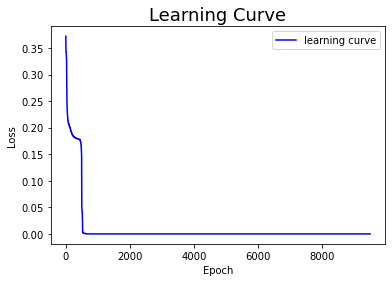

In [161]:
xorNN.trainNetwork(X_train, Y_train)

In [165]:
Y_predict = xorNN.predict(X_train)

Predict:0, [0. 0.]
Predict:1, [0. 1.]
Predict:2, [0.1 0.1]
Predict:3, [0.1 0.9]
Predict:4, [0.2 0.2]
Predict:5, [0.2 0.8]
Predict:6, [0.3 0.3]
Predict:7, [0.3 0.7]
Predict:8, [0.4 0.4]
Predict:9, [0.4 0.6]
Predict:10, [0.5 0.5]
Predict:11, [0.6 0.6]
Predict:12, [0.6 0.4]
Predict:13, [0.7 0.7]
Predict:14, [0.7 0.3]
Predict:15, [0.8 0.8]
Predict:16, [0.8 0.2]
Predict:17, [0.9 0.9]
Predict:18, [0.9 0.1]
Predict:19, [1. 1.]
Predict:20, [1. 0.]


print Red 0.00274255222230981
print Blue 0.9995391128813144
print Red 0.002683947572608318
print Blue 0.9995391124672968
print Red 0.0026357081801360563
print Blue 0.9995390202451603
print Red 0.002597014590688986
print Blue 0.9995272823704303
print Red 0.00256717859001891
print Blue 0.9948198810936018
print Red 0.0025456260124798575
print Red 0.0025318824656390348
print Blue 0.9922605332270915
print Red 0.0025255614863651686
print Blue 0.999373179596656
print Red 0.0025263547334907627
print Blue 0.9994237999909305
print Red 0.0025340238947849816
print Blue 0.9994251661461685
print Red 0.0025483940450435794
print Blue 0.9994252043974613


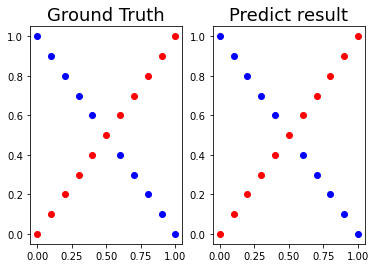

In [166]:
show_result(X_train, Y_train, Y_predict)

In [173]:
X_train, Y_train = GenerateData.generate_linear()
linearNN = SimpleNN()

In [174]:
linearNN.addLayer(n_neuron=2, n_inputs=2)
linearNN.addLayer(n_neuron=2)
linearNN.addLayer(n_neuron=1)

In [175]:
linearNN.describe()

----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------


In [176]:
linearNN.setting(l_rate=0.2, n_epoch=3000, haveLearningCurve=True)

----Training Setting----
Epoch:3000
Learning Rate:0.2
Learning Curve:True
------------------------


----Training Setting----
Epoch:3000
Learning Rate:0.2
Learning Curve:True
------------------------
----Network Description----
total 3 layers
2 hidden layer
one output layer
-Layer 1-
2 neurons
neuron0:
weight:[-0.7312715117751976, 0.6948674738744653]
bias:0.5275492379532281
neuron1:
weight:[-0.4898619485211566, -0.009129825816118098]
bias:-0.10101787042252375
-Layer 2-
2 neurons
neuron0:
weight:[0.3031859454455259, 0.5774467022710263]
bias:-0.8122808264515302
neuron1:
weight:[-0.9433050469559874, 0.6715302078397394]
bias:-0.13446586418989326
-Layer 3-
1 neurons
neuron0:
weight:[0.524560164915884, -0.9957878932977786]
bias:-0.10922561189039715
---------------------------
==epoch=0, lrate=0.200, error=0.249==
==epoch=1, lrate=0.200, error=0.249==
==epoch=2, lrate=0.200, error=0.249==
==epoch=3, lrate=0.200, error=0.248==
==epoch=4, lrate=0.200, error=0.247==
==epoch=5, lrate=0.200, error=0.246==
==epoch=6, lrate=0.200, error=0.245==
==epoch=7, lrate=0.200, error=0.243==
==epoch=8, lrate

==epoch=239, lrate=0.200, error=0.005==
==epoch=240, lrate=0.200, error=0.005==
==epoch=241, lrate=0.200, error=0.005==
==epoch=242, lrate=0.200, error=0.005==
==epoch=243, lrate=0.200, error=0.005==
==epoch=244, lrate=0.200, error=0.005==
==epoch=245, lrate=0.200, error=0.005==
==epoch=246, lrate=0.200, error=0.005==
==epoch=247, lrate=0.200, error=0.005==
==epoch=248, lrate=0.200, error=0.005==
==epoch=249, lrate=0.200, error=0.005==
==epoch=250, lrate=0.200, error=0.005==
==epoch=251, lrate=0.200, error=0.005==
==epoch=252, lrate=0.200, error=0.005==
==epoch=253, lrate=0.200, error=0.005==
==epoch=254, lrate=0.200, error=0.005==
==epoch=255, lrate=0.200, error=0.005==
==epoch=256, lrate=0.200, error=0.005==
==epoch=257, lrate=0.200, error=0.005==
==epoch=258, lrate=0.200, error=0.005==
==epoch=259, lrate=0.200, error=0.005==
==epoch=260, lrate=0.200, error=0.005==
==epoch=261, lrate=0.200, error=0.005==
==epoch=262, lrate=0.200, error=0.005==
==epoch=263, lrate=0.200, error=0.005==


==epoch=480, lrate=0.200, error=0.002==
==epoch=481, lrate=0.200, error=0.002==
==epoch=482, lrate=0.200, error=0.002==
==epoch=483, lrate=0.200, error=0.002==
==epoch=484, lrate=0.200, error=0.002==
==epoch=485, lrate=0.200, error=0.002==
==epoch=486, lrate=0.200, error=0.002==
==epoch=487, lrate=0.200, error=0.002==
==epoch=488, lrate=0.200, error=0.002==
==epoch=489, lrate=0.200, error=0.002==
==epoch=490, lrate=0.200, error=0.002==
==epoch=491, lrate=0.200, error=0.002==
==epoch=492, lrate=0.200, error=0.002==
==epoch=493, lrate=0.200, error=0.002==
==epoch=494, lrate=0.200, error=0.002==
==epoch=495, lrate=0.200, error=0.002==
==epoch=496, lrate=0.200, error=0.002==
==epoch=497, lrate=0.200, error=0.002==
==epoch=498, lrate=0.200, error=0.002==
==epoch=499, lrate=0.200, error=0.002==
==epoch=500, lrate=0.200, error=0.002==
==epoch=501, lrate=0.200, error=0.002==
==epoch=502, lrate=0.200, error=0.002==
==epoch=503, lrate=0.200, error=0.002==
==epoch=504, lrate=0.200, error=0.002==


==epoch=710, lrate=0.200, error=0.001==
==epoch=711, lrate=0.200, error=0.001==
==epoch=712, lrate=0.200, error=0.001==
==epoch=713, lrate=0.200, error=0.001==
==epoch=714, lrate=0.200, error=0.001==
==epoch=715, lrate=0.200, error=0.001==
==epoch=716, lrate=0.200, error=0.001==
==epoch=717, lrate=0.200, error=0.001==
==epoch=718, lrate=0.200, error=0.001==
==epoch=719, lrate=0.200, error=0.001==
==epoch=720, lrate=0.200, error=0.001==
==epoch=721, lrate=0.200, error=0.001==
==epoch=722, lrate=0.200, error=0.001==
==epoch=723, lrate=0.200, error=0.001==
==epoch=724, lrate=0.200, error=0.001==
==epoch=725, lrate=0.200, error=0.001==
==epoch=726, lrate=0.200, error=0.001==
==epoch=727, lrate=0.200, error=0.001==
==epoch=728, lrate=0.200, error=0.001==
==epoch=729, lrate=0.200, error=0.001==
==epoch=730, lrate=0.200, error=0.001==
==epoch=731, lrate=0.200, error=0.001==
==epoch=732, lrate=0.200, error=0.001==
==epoch=733, lrate=0.200, error=0.001==
==epoch=734, lrate=0.200, error=0.001==


==epoch=940, lrate=0.200, error=0.001==
==epoch=941, lrate=0.200, error=0.001==
==epoch=942, lrate=0.200, error=0.001==
==epoch=943, lrate=0.200, error=0.001==
==epoch=944, lrate=0.200, error=0.001==
==epoch=945, lrate=0.200, error=0.001==
==epoch=946, lrate=0.200, error=0.001==
==epoch=947, lrate=0.200, error=0.001==
==epoch=948, lrate=0.200, error=0.001==
==epoch=949, lrate=0.200, error=0.001==
==epoch=950, lrate=0.200, error=0.001==
==epoch=951, lrate=0.200, error=0.001==
==epoch=952, lrate=0.200, error=0.001==
==epoch=953, lrate=0.200, error=0.001==
==epoch=954, lrate=0.200, error=0.001==
==epoch=955, lrate=0.200, error=0.001==
==epoch=956, lrate=0.200, error=0.001==
==epoch=957, lrate=0.200, error=0.001==
==epoch=958, lrate=0.200, error=0.001==
==epoch=959, lrate=0.200, error=0.001==
==epoch=960, lrate=0.200, error=0.001==
==epoch=961, lrate=0.200, error=0.001==
==epoch=962, lrate=0.200, error=0.001==
==epoch=963, lrate=0.200, error=0.001==
==epoch=964, lrate=0.200, error=0.001==


==epoch=1183, lrate=0.200, error=0.000==
==epoch=1184, lrate=0.200, error=0.000==
==epoch=1185, lrate=0.200, error=0.000==
==epoch=1186, lrate=0.200, error=0.000==
==epoch=1187, lrate=0.200, error=0.000==
==epoch=1188, lrate=0.200, error=0.000==
==epoch=1189, lrate=0.200, error=0.000==
==epoch=1190, lrate=0.200, error=0.000==
==epoch=1191, lrate=0.200, error=0.000==
==epoch=1192, lrate=0.200, error=0.000==
==epoch=1193, lrate=0.200, error=0.000==
==epoch=1194, lrate=0.200, error=0.000==
==epoch=1195, lrate=0.200, error=0.000==
==epoch=1196, lrate=0.200, error=0.000==
==epoch=1197, lrate=0.200, error=0.000==
==epoch=1198, lrate=0.200, error=0.000==
==epoch=1199, lrate=0.200, error=0.000==
==epoch=1200, lrate=0.200, error=0.000==
==epoch=1201, lrate=0.200, error=0.000==
==epoch=1202, lrate=0.200, error=0.000==
==epoch=1203, lrate=0.200, error=0.000==
==epoch=1204, lrate=0.200, error=0.000==
==epoch=1205, lrate=0.200, error=0.000==
==epoch=1206, lrate=0.200, error=0.000==
==epoch=1207, lr

==epoch=1429, lrate=0.200, error=0.000==
==epoch=1430, lrate=0.200, error=0.000==
==epoch=1431, lrate=0.200, error=0.000==
==epoch=1432, lrate=0.200, error=0.000==
==epoch=1433, lrate=0.200, error=0.000==
==epoch=1434, lrate=0.200, error=0.000==
==epoch=1435, lrate=0.200, error=0.000==
==epoch=1436, lrate=0.200, error=0.000==
==epoch=1437, lrate=0.200, error=0.000==
==epoch=1438, lrate=0.200, error=0.000==
==epoch=1439, lrate=0.200, error=0.000==
==epoch=1440, lrate=0.200, error=0.000==
==epoch=1441, lrate=0.200, error=0.000==
==epoch=1442, lrate=0.200, error=0.000==
==epoch=1443, lrate=0.200, error=0.000==
==epoch=1444, lrate=0.200, error=0.000==
==epoch=1445, lrate=0.200, error=0.000==
==epoch=1446, lrate=0.200, error=0.000==
==epoch=1447, lrate=0.200, error=0.000==
==epoch=1448, lrate=0.200, error=0.000==
==epoch=1449, lrate=0.200, error=0.000==
==epoch=1450, lrate=0.200, error=0.000==
==epoch=1451, lrate=0.200, error=0.000==
==epoch=1452, lrate=0.200, error=0.000==
==epoch=1453, lr

==epoch=1676, lrate=0.200, error=0.000==
==epoch=1677, lrate=0.200, error=0.000==
==epoch=1678, lrate=0.200, error=0.000==
==epoch=1679, lrate=0.200, error=0.000==
==epoch=1680, lrate=0.200, error=0.000==
==epoch=1681, lrate=0.200, error=0.000==
==epoch=1682, lrate=0.200, error=0.000==
==epoch=1683, lrate=0.200, error=0.000==
==epoch=1684, lrate=0.200, error=0.000==
==epoch=1685, lrate=0.200, error=0.000==
==epoch=1686, lrate=0.200, error=0.000==
==epoch=1687, lrate=0.200, error=0.000==
==epoch=1688, lrate=0.200, error=0.000==
==epoch=1689, lrate=0.200, error=0.000==
==epoch=1690, lrate=0.200, error=0.000==
==epoch=1691, lrate=0.200, error=0.000==
==epoch=1692, lrate=0.200, error=0.000==
==epoch=1693, lrate=0.200, error=0.000==
==epoch=1694, lrate=0.200, error=0.000==
==epoch=1695, lrate=0.200, error=0.000==
==epoch=1696, lrate=0.200, error=0.000==
==epoch=1697, lrate=0.200, error=0.000==
==epoch=1698, lrate=0.200, error=0.000==
==epoch=1699, lrate=0.200, error=0.000==
==epoch=1700, lr

==epoch=1920, lrate=0.200, error=0.000==
==epoch=1921, lrate=0.200, error=0.000==
==epoch=1922, lrate=0.200, error=0.000==
==epoch=1923, lrate=0.200, error=0.000==
==epoch=1924, lrate=0.200, error=0.000==
==epoch=1925, lrate=0.200, error=0.000==
==epoch=1926, lrate=0.200, error=0.000==
==epoch=1927, lrate=0.200, error=0.000==
==epoch=1928, lrate=0.200, error=0.000==
==epoch=1929, lrate=0.200, error=0.000==
==epoch=1930, lrate=0.200, error=0.000==
==epoch=1931, lrate=0.200, error=0.000==
==epoch=1932, lrate=0.200, error=0.000==
==epoch=1933, lrate=0.200, error=0.000==
==epoch=1934, lrate=0.200, error=0.000==
==epoch=1935, lrate=0.200, error=0.000==
==epoch=1936, lrate=0.200, error=0.000==
==epoch=1937, lrate=0.200, error=0.000==
==epoch=1938, lrate=0.200, error=0.000==
==epoch=1939, lrate=0.200, error=0.000==
==epoch=1940, lrate=0.200, error=0.000==
==epoch=1941, lrate=0.200, error=0.000==
==epoch=1942, lrate=0.200, error=0.000==
==epoch=1943, lrate=0.200, error=0.000==
==epoch=1944, lr

==epoch=2159, lrate=0.200, error=0.000==
==epoch=2160, lrate=0.200, error=0.000==
==epoch=2161, lrate=0.200, error=0.000==
==epoch=2162, lrate=0.200, error=0.000==
==epoch=2163, lrate=0.200, error=0.000==
==epoch=2164, lrate=0.200, error=0.000==
==epoch=2165, lrate=0.200, error=0.000==
==epoch=2166, lrate=0.200, error=0.000==
==epoch=2167, lrate=0.200, error=0.000==
==epoch=2168, lrate=0.200, error=0.000==
==epoch=2169, lrate=0.200, error=0.000==
==epoch=2170, lrate=0.200, error=0.000==
==epoch=2171, lrate=0.200, error=0.000==
==epoch=2172, lrate=0.200, error=0.000==
==epoch=2173, lrate=0.200, error=0.000==
==epoch=2174, lrate=0.200, error=0.000==
==epoch=2175, lrate=0.200, error=0.000==
==epoch=2176, lrate=0.200, error=0.000==
==epoch=2177, lrate=0.200, error=0.000==
==epoch=2178, lrate=0.200, error=0.000==
==epoch=2179, lrate=0.200, error=0.000==
==epoch=2180, lrate=0.200, error=0.000==
==epoch=2181, lrate=0.200, error=0.000==
==epoch=2182, lrate=0.200, error=0.000==
==epoch=2183, lr

==epoch=2392, lrate=0.200, error=0.000==
==epoch=2393, lrate=0.200, error=0.000==
==epoch=2394, lrate=0.200, error=0.000==
==epoch=2395, lrate=0.200, error=0.000==
==epoch=2396, lrate=0.200, error=0.000==
==epoch=2397, lrate=0.200, error=0.000==
==epoch=2398, lrate=0.200, error=0.000==
==epoch=2399, lrate=0.200, error=0.000==
==epoch=2400, lrate=0.200, error=0.000==
==epoch=2401, lrate=0.200, error=0.000==
==epoch=2402, lrate=0.200, error=0.000==
==epoch=2403, lrate=0.200, error=0.000==
==epoch=2404, lrate=0.200, error=0.000==
==epoch=2405, lrate=0.200, error=0.000==
==epoch=2406, lrate=0.200, error=0.000==
==epoch=2407, lrate=0.200, error=0.000==
==epoch=2408, lrate=0.200, error=0.000==
==epoch=2409, lrate=0.200, error=0.000==
==epoch=2410, lrate=0.200, error=0.000==
==epoch=2411, lrate=0.200, error=0.000==
==epoch=2412, lrate=0.200, error=0.000==
==epoch=2413, lrate=0.200, error=0.000==
==epoch=2414, lrate=0.200, error=0.000==
==epoch=2415, lrate=0.200, error=0.000==
==epoch=2416, lr

==epoch=2630, lrate=0.200, error=0.000==
==epoch=2631, lrate=0.200, error=0.000==
==epoch=2632, lrate=0.200, error=0.000==
==epoch=2633, lrate=0.200, error=0.000==
==epoch=2634, lrate=0.200, error=0.000==
==epoch=2635, lrate=0.200, error=0.000==
==epoch=2636, lrate=0.200, error=0.000==
==epoch=2637, lrate=0.200, error=0.000==
==epoch=2638, lrate=0.200, error=0.000==
==epoch=2639, lrate=0.200, error=0.000==
==epoch=2640, lrate=0.200, error=0.000==
==epoch=2641, lrate=0.200, error=0.000==
==epoch=2642, lrate=0.200, error=0.000==
==epoch=2643, lrate=0.200, error=0.000==
==epoch=2644, lrate=0.200, error=0.000==
==epoch=2645, lrate=0.200, error=0.000==
==epoch=2646, lrate=0.200, error=0.000==
==epoch=2647, lrate=0.200, error=0.000==
==epoch=2648, lrate=0.200, error=0.000==
==epoch=2649, lrate=0.200, error=0.000==
==epoch=2650, lrate=0.200, error=0.000==
==epoch=2651, lrate=0.200, error=0.000==
==epoch=2652, lrate=0.200, error=0.000==
==epoch=2653, lrate=0.200, error=0.000==
==epoch=2654, lr

==epoch=2864, lrate=0.200, error=0.000==
==epoch=2865, lrate=0.200, error=0.000==
==epoch=2866, lrate=0.200, error=0.000==
==epoch=2867, lrate=0.200, error=0.000==
==epoch=2868, lrate=0.200, error=0.000==
==epoch=2869, lrate=0.200, error=0.000==
==epoch=2870, lrate=0.200, error=0.000==
==epoch=2871, lrate=0.200, error=0.000==
==epoch=2872, lrate=0.200, error=0.000==
==epoch=2873, lrate=0.200, error=0.000==
==epoch=2874, lrate=0.200, error=0.000==
==epoch=2875, lrate=0.200, error=0.000==
==epoch=2876, lrate=0.200, error=0.000==
==epoch=2877, lrate=0.200, error=0.000==
==epoch=2878, lrate=0.200, error=0.000==
==epoch=2879, lrate=0.200, error=0.000==
==epoch=2880, lrate=0.200, error=0.000==
==epoch=2881, lrate=0.200, error=0.000==
==epoch=2882, lrate=0.200, error=0.000==
==epoch=2883, lrate=0.200, error=0.000==
==epoch=2884, lrate=0.200, error=0.000==
==epoch=2885, lrate=0.200, error=0.000==
==epoch=2886, lrate=0.200, error=0.000==
==epoch=2887, lrate=0.200, error=0.000==
==epoch=2888, lr

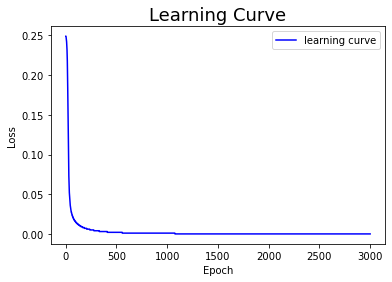

In [177]:
linearNN.trainNetwork(X_train, Y_train)

Predict:0, [0.0346209  0.85183562]
Predict:1, [0.75678443 0.17744356]
Predict:2, [0.31603955 0.3921704 ]
Predict:3, [0.32312867 0.54039455]
Predict:4, [0.55210695 0.5206143 ]
Predict:5, [0.17452118 0.28091642]
Predict:6, [0.28416365 0.20862772]
Predict:7, [0.2909304 0.956827 ]
Predict:8, [0.51800091 0.28119467]
Predict:9, [0.98958472 0.74311901]
Predict:10, [0.89343147 0.17244108]
Predict:11, [0.83048226 0.04654017]
Predict:12, [0.71372643 0.10070516]
Predict:13, [0.94050114 0.40372954]
Predict:14, [0.1517271  0.91137432]
Predict:15, [0.45152178 0.51760735]
Predict:16, [0.86882906 0.14135128]
Predict:17, [0.202695   0.62956556]
Predict:18, [0.8894237  0.95990232]
Predict:19, [0.26260415 0.79974186]
Predict:20, [0.46240627 0.7081852 ]
Predict:21, [0.08810454 0.6188951 ]
Predict:22, [0.00518934 0.94214952]
Predict:23, [0.88919863 0.08834453]
Predict:24, [0.33193752 0.22789657]
Predict:25, [0.82723329 0.87067773]
Predict:26, [0.64043577 0.31323447]
Predict:27, [0.62103847 0.34185059]
Pred

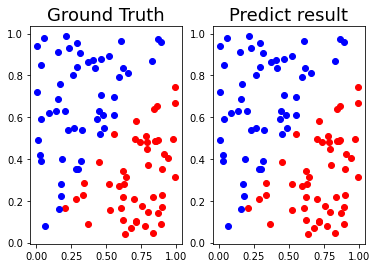

In [178]:
Y_predict = linearNN.predict(X_train)
show_result(X_train, Y_train, Y_predict)

In [ ]:
seed(1)
X_train, Y_train = generate_XOR_easy()
network = establishNN(2,2,2,1)

l_rate = 4
n_epoch = 9500
n_outputs = 1
trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True)

In [ ]:
Y_predict = predictModel(network, X_train)
print(Y_predict)
show_result(X_train, Y_train, Y_predict)

In [ ]:
seed(1)
X_train, Y_train = generate_linear(n=100)
network = establishNN(2,2,2,1)

l_rate = 0.5
n_epoch = 2000
n_outputs = 1
trainNetwork(network, X_train, Y_train, l_rate, n_epoch, n_outputs, havelearningCurve=True)

In [ ]:
Y_predict = predictModel(network, X_train)
show_result(X_train, Y_train, Y_predict)

In [ ]:
network

In [ ]:
X_train

In [ ]:
Y_train

In [ ]:
uniform(-1,1)

In [ ]:
a = [1,2]
b = a.copy()
a.clear()
b[0]= 30
b

In [ ]:
def test(**karg):
    print(karg)
test(n_input=3)